# 悉尼天气预测

通过对悉尼当天的各种气象因素（湿度，压力，风向等）对第二天是否下雨，降水量多少进行预测。

数据集来源：https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## 导入所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = None
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest,f_regression,f_classif,chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 数据清理

读取数据集，检查数据类型以及缺失值数量。这里只读取悉尼天气数据，因此筛选掉其他城市的气象数据。

In [2]:
weather=pd.read_csv('weatheraus.csv')
weather_sydney=weather[weather['Location']=='Sydney']

In [3]:
weather_sydney.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
29497,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,6.0,Yes
29498,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,6.6,Yes
29499,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,18.8,Yes
29500,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,77.4,Yes
29501,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,1.6,Yes


In [4]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3331 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3331 non-null object
RISK_MM          3337 non-null float

In [5]:
weather_sydney.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,3334.000000,3335.000000,3331.000000,3286.000000,3321.000000,2301.000000,3311.000000,3312.000000,3323.000000,3324.000000,3317.000000,3318.000000,2771.000000,2776.000000,3333.000000,3333.000000,3337.000000
mean,14.865057,23.002339,3.330231,5.187432,7.179374,41.761408,15.070674,19.335447,68.229010,54.699158,1018.346156,1016.018774,4.181523,4.218660,17.819742,21.533333,3.319868
std,4.553641,4.494638,9.895172,2.777407,3.810886,13.007523,7.079724,7.482554,15.085355,16.293530,7.021571,7.032211,2.749578,2.641885,4.897177,4.303737,9.885066
min,4.300000,11.700000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000,6.400000,10.200000,0.000000
25%,11.000000,19.600000,0.000000,3.200000,4.300000,31.000000,9.000000,15.000000,58.000000,44.000000,1013.700000,1011.300000,1.000000,1.000000,13.800000,18.400000,0.000000
50%,14.900000,22.800000,0.000000,4.800000,8.300000,41.000000,15.000000,19.000000,69.000000,56.000000,1018.600000,1016.300000,5.000000,4.000000,18.200000,21.300000,0.000000
75%,18.700000,26.000000,1.400000,7.000000,10.200000,50.000000,20.000000,24.000000,80.000000,65.000000,1023.100000,1020.800000,7.000000,7.000000,21.700000,24.500000,1.400000
max,27.600000,45.800000,119.400000,18.400000,13.600000,96.000000,54.000000,57.000000,100.000000,99.000000,1039.000000,1036.700000,9.000000,8.000000,36.500000,44.700000,119.400000


从info()中可看出缺失值主要存在于每日最强风的风力与风速，以及云层厚度。接下来检查数据集中是否有重复数据，例如同一天的气象数据出现了多次。

In [6]:
weather_sydney=weather_sydney.drop_duplicates(subset='Date', keep='first', inplace=False)
weather_sydney.shape[0]

3337

数据集依旧是3337行，所以数据集中并没有重复日期。

预测变量‘RainToday’（今日是否下雨），‘Rainfall’（今日降水量）中各有6个缺失值，但是此变量值可由上一天的‘RainTomorrow’（明日是否下雨）及‘RISK_MM’（明日降水量）推测出，所以‘RainToday’与‘Rainfall’的缺失值可以用此法填补。

In [7]:
for index in weather_sydney.index:
    if pd.isnull(weather_sydney.loc[index,'RainToday']):
        weather_sydney.loc[index,['RainToday']]=weather_sydney.loc[index-1,['RainTomorrow']][0]
    if pd.isnull(weather_sydney.loc[index,'Rainfall']):
        weather_sydney.loc[index,['Rainfall']]=weather_sydney.loc[index-1,['RISK_MM']][0]

对于其余的缺失值我们选择将其所在行删除，最后剩余1692行数据。之后剔除不需要的列‘Date’，‘Location’，‘RainToday’，‘RainTomorrow’。

In [8]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3337 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3337 non-null object
RISK_MM          3337 non-null float

In [9]:
weather_sydney=weather_sydney.dropna()
weather_sydney=weather_sydney.drop(columns=['Date','Location'])

对于类别变量，我们将‘Yes’和‘No’统一转化为1和0，并将风向变量向量化，即独热编码。

In [10]:
weather_sydney2=weather_sydney

In [11]:
weather_sydney=weather_sydney.replace('Yes',1)
weather_sydney=weather_sydney.replace('No',0)
weather_sydney= pd.get_dummies(weather_sydney,columns = ['WindGustDir','WindDir9am','WindDir3pm'],drop_first=True)

## 基础分析

首先分析风向因素，这里选取第二天会下雨的数据（RainTomorrow=Yes），统计下雨前一天的风向分布。

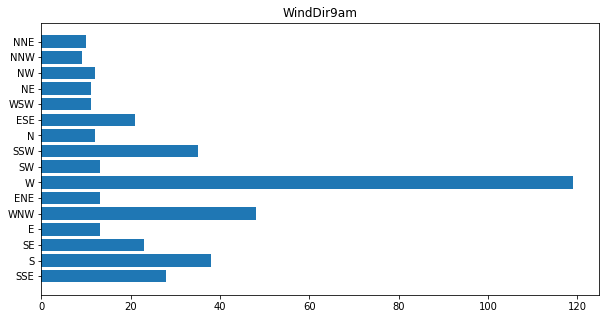

In [12]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir9am'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir9am')
plt.show()

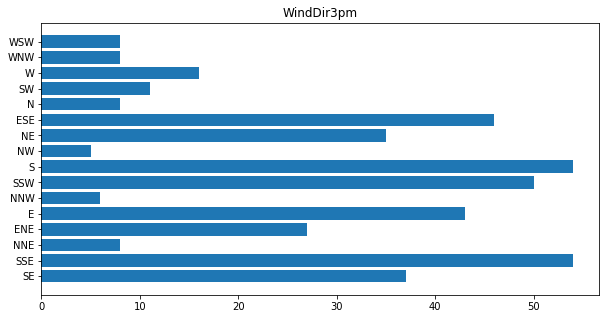

In [13]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir3pm'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir3pm')
plt.show()

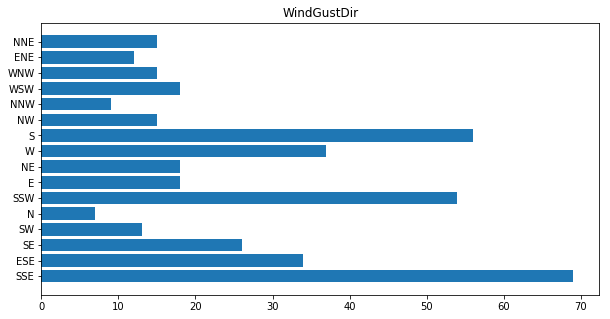

In [14]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindGustDir'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindGustDir')
plt.show()

可看出，如果上午9点风向为西风，下午3点风向大致为南风或东风，当日最大风为偏西南风时，第二天下雨情况居多。悉尼地处澳大利亚东南部，除了上午9点是情况，其他情况皆符合常理。

接下来分析云层厚度与降水的关系。

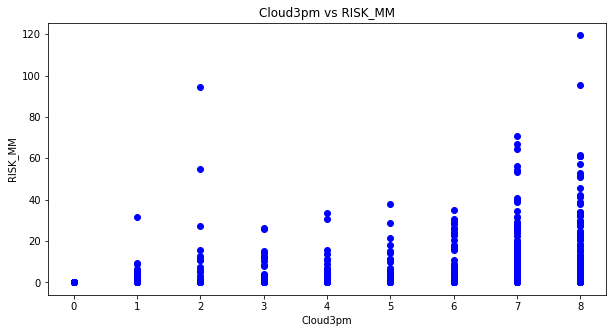

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Cloud3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Cloud3pm vs RISK_MM')
plt.xlabel('Cloud3pm')
plt.ylabel('RISK_MM')
plt.show()

除了个别极端情况，总体上看随着云层厚度增加，第二天降水量有上升趋势。

湿度与降水也可观察到正相关关系。

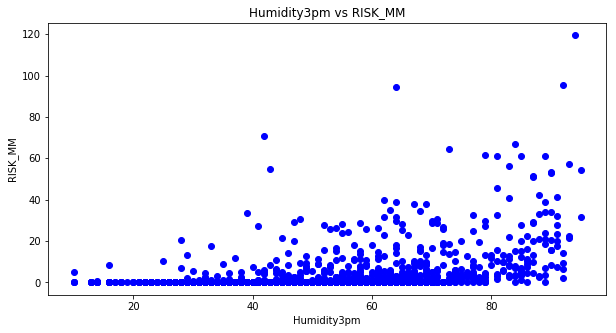

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Humidity3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Humidity3pm vs RISK_MM')
plt.xlabel('Humidity3pm')
plt.ylabel('RISK_MM')
plt.show()

今天的降水量之间是否对明天的降水量有影响？由散点图看是呈负相关。

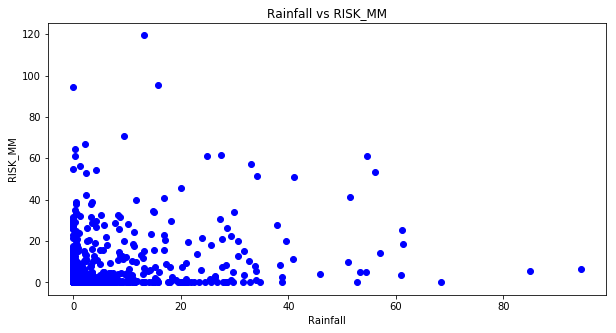

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Rainfall'],weather_sydney2['RISK_MM'],color='b')
plt.title('Rainfall vs RISK_MM')
plt.xlabel('Rainfall')
plt.ylabel('RISK_MM')
plt.show()

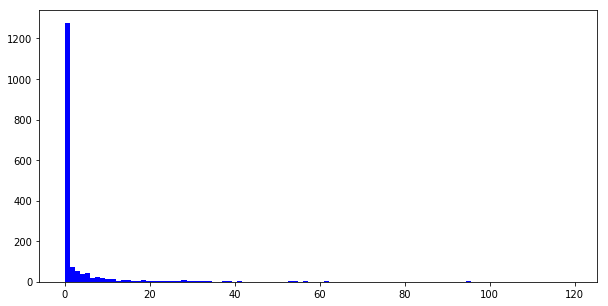

In [18]:
plt.figure(figsize=(10,5))
plt.hist(weather_sydney2['RISK_MM'],color='b',bins=100)

plt.show()

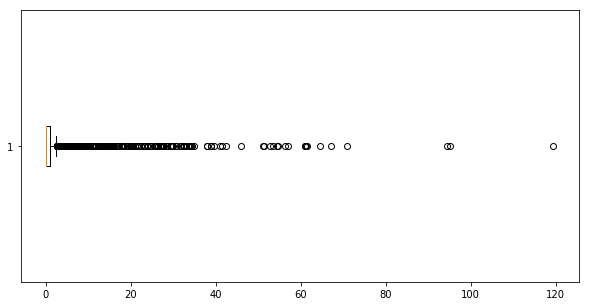

In [19]:
plt.figure(figsize=(10,5))
plt.boxplot(weather_sydney2['RISK_MM'],vert=False)
plt.show()

降水量似乎呈泊松分布，应考虑适不适合使用回归模型预测降水量。

## 建模

### 线性回归（PCA）

查看变量间相关系数

In [20]:
y=weather_sydney['RISK_MM']
X0=weather_sydney2[weather_sydney2.columns.difference(['RainToday','RainTomorrow','RISK_MM','WindDir3pm','WindDir9am','WindGustDir','WindGustSpeed' ,'WindSpeed3pm' ,'WindSpeed9am'])]

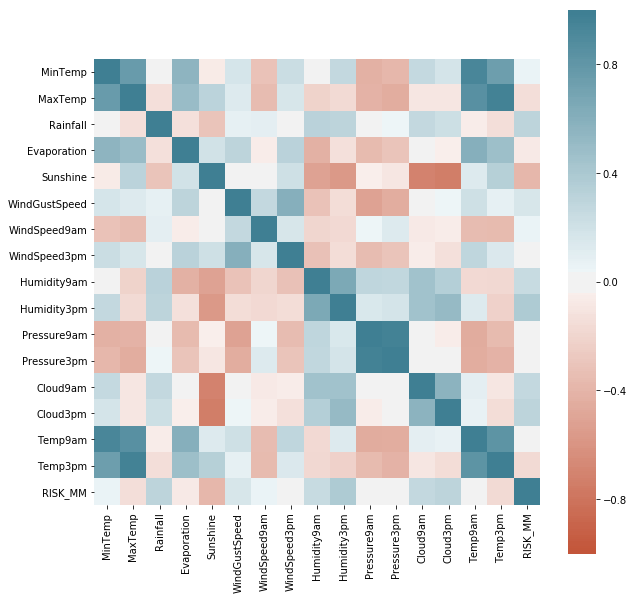

In [21]:

plt.figure(figsize=(10,10))
sns.heatmap(weather_sydney2.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()
 

In [22]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X0, y,
                                                    test_size=0.30,
                                                   )
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


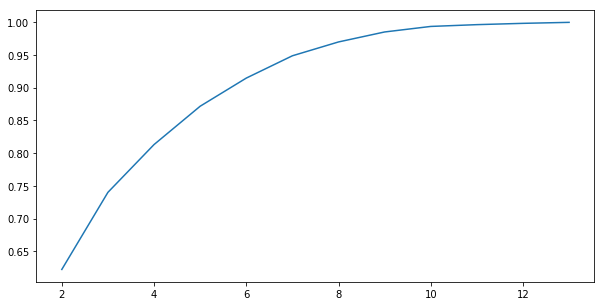

In [23]:

from sklearn.decomposition import PCA
ratio=[]
for n in [2,3,4,5,6,7,8,9,10,11,12,13]:
    pca=PCA(n_components=n)
    pca.fit(X_train)  
    ratio.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize=(10,5))
plt.plot([2,3,4,5,6,7,8,9,10,11,12,13],ratio)
plt.show()

设置阈值为0.9，则由图知特征数取6。

In [24]:
from sklearn.pipeline import make_pipeline

std_clf = make_pipeline(PCA(n_components=6), LinearRegression())
std_clf.fit(X_train, y_train)
y_pred= std_clf.predict(X_test)

In [25]:
r2_score( y_test, y_pred)

0.21919202324612186

### 线性回归（特征选择）

挑选其中对因变量影响最大的20个自变量

In [26]:
y=weather_sydney['RISK_MM']
X1=weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]
best=SelectKBest(f_regression, k=10)
best.fit(X1,y)

SelectKBest(k=10, score_func=<function f_regression at 0x000001C1F9CD7598>)

In [27]:
pd.DataFrame(data={'feature':X1.columns,'score':best.scores_}).sort_values(by=['score'],ascending=0)

,feature,score
3,Humidity3pm,294.698309
10,Sunshine,285.637046
0,Cloud3pm,175.451614
9,Rainfall,166.525322
1,Cloud9am,134.489998
4,Humidity9am,118.191044
11,Temp3pm,50.606492
58,WindGustSpeed,50.494545
5,MaxTemp,37.570661
35,WindDir9am_S,33.255359


In [28]:
columns=list(pd.DataFrame(data={'feature':X1.columns,'score':best.scores_}).sort_values(by=['score'],ascending=0)['feature'][0:20])
print(columns)

['Humidity3pm', 'Sunshine', 'Cloud3pm', 'Rainfall', 'Cloud9am', 'Humidity9am', 'Temp3pm', 'WindGustSpeed', 'MaxTemp', 'WindDir9am_S', 'WindDir3pm_SSW', 'WindGustDir_W', 'WindGustDir_S', 'WindDir3pm_S', 'WindGustDir_SE', 'WindGustDir_ESE', 'WindDir3pm_SSE', 'WindDir9am_SSW', 'WindGustDir_SSE', 'WindGustDir_ENE']


接下来进行调参。

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
x=range(21)
x=x[1:20]
train_er=[]
test_er=[]
for c in x:
    X_train, X_test, y_train, y_test = train_test_split(weather_sydney[columns[0:c]], weather_sydney['RISK_MM'], test_size=0.33, random_state=42)
    lin = LinearRegression()

    
    lin.fit(X_train,y_train)
    Y_pre=lin.predict(X_test)
    Y_trpre=lin.predict(X_train)
    train_er.append(mean_squared_error(y_train,Y_trpre))
    test_er.append(mean_squared_error(y_test,Y_pre))

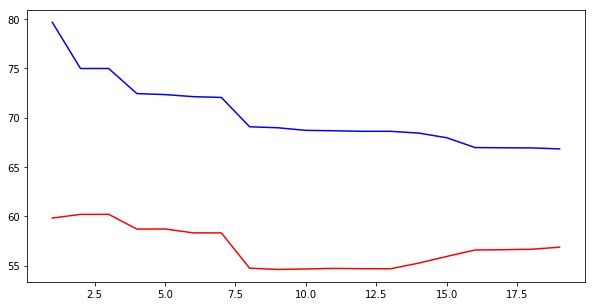

In [30]:
plt.figure(figsize=(10,5))
plt.plot(x,train_er,color='b')
plt.plot(x,test_er,color='r')
plt.show()

可见取前8个特征数较为合适，此时训练集误差达到最小值。

In [31]:
lin = LinearRegression()
lin.fit(weather_sydney[columns[0:8]], weather_sydney['RISK_MM'])
pd.DataFrame(data={'feature':columns[0:8],'coef':lin.coef_})

,feature,coef
0,Humidity3pm,0.152114
1,Sunshine,-0.470213
2,Cloud3pm,0.006298
3,Rainfall,0.160470
4,Cloud9am,-0.131530
5,Humidity9am,0.008717
6,Temp3pm,-0.092645
7,WindGustSpeed,0.152172


In [32]:
y_pred = lin.predict(weather_sydney[columns[0:8]])
r2_score( weather_sydney['RISK_MM'], y_pred)

0.25271663196425176

在此我们得到模型的$R^2$约为0.25。首先观察模型系数，湿度的系数最高，说明湿度上升会增加第二天的降水量。上午9时的云层厚度对第二天的降水量有负作用。然而我们注意到，在这个模型里，相邻两天的降水量会互相影响。

## 逻辑回归

尝试仅预测是否下雨，即分类。这里我们使用逻辑回归。使用前先剔除掉数据集中记录明日降水量的‘RISK_MM’，并将‘RainTomorrow’作为预测对象。

In [33]:
y=weather_sydney['RainTomorrow']
X=weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]
best=SelectKBest(f_classif, k=10)
best.fit(X,y)


SelectKBest(k=10, score_func=<function f_classif at 0x000001C1F9CD7400>)

In [34]:
columns=(X.columns[best.get_support(indices=True)])
X=best.transform(X)

In [35]:
weather_sydney['RainTomorrow'].value_counts()

0    1276
1     416
Name: RainTomorrow, dtype: int64

数据类别有些不平衡，明显下雨天的样本过少。因此我们使用交叉验证法对类别权重进行调参。

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Best parameters : {'class_weight': {0: 0.4289473684210526, 1: 0.5710526315789475}}


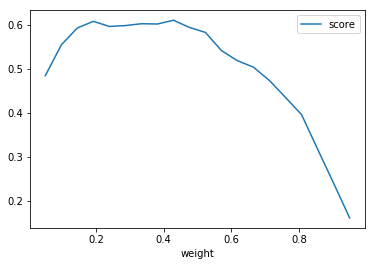

In [36]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[columns[0:9]], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)
    
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [37]:
cv_results=pd.DataFrame(gsc.cv_results_)
cv_results

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\skle

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.005879,0.002209,0.001396,6.598850e-04,"{0: 0.05, 1: 0.95}","{'class_weight': {0: 0.05, 1: 0.95}}",0.482759,0.495413,0.469565,0.490196,...,0.491335,0.494289,0.483871,0.494312,0.489209,0.486322,0.494867,0.494845,0.490322,0.004548
1,0.004488,0.000669,0.000898,2.992394e-04,"{0: 0.09736842105263158, 1: 0.9026315789473685}","{'class_weight': {0: 0.09736842105263158, 1: 0...",0.547368,0.602410,0.551020,0.527473,...,0.557500,0.566751,0.558714,0.559406,0.557908,0.545900,0.562577,0.555831,0.558268,0.005303
2,0.004088,0.000697,0.000898,5.375656e-04,"{0: 0.14473684210526316, 1: 0.8552631578947368}","{'class_weight': {0: 0.14473684210526316, 1: 0...",0.578313,0.666667,0.575000,0.608696,...,0.601156,0.604585,0.597143,0.602026,0.595989,0.596844,0.599713,0.597143,0.599350,0.004668
3,0.003987,0.000773,0.000900,2.999143e-04,"{0: 0.19210526315789472, 1: 0.8078947368421052}","{'class_weight': {0: 0.19210526315789472, 1: 0...",0.589744,0.636364,0.578947,0.603175,...,0.613459,0.611801,0.605016,0.617785,0.606532,0.611367,0.611285,0.607874,0.610388,0.003477
4,0.004385,0.000659,0.000798,3.990896e-04,"{0: 0.23947368421052628, 1: 0.7605263157894737}","{'class_weight': {0: 0.23947368421052628, 1: 0...",0.520548,0.612903,0.553846,0.612903,...,0.614094,0.605042,0.600671,0.611018,0.614601,0.606260,0.606061,0.608108,0.608875,0.005256
5,0.004587,0.001197,0.001099,3.056241e-04,"{0: 0.28684210526315784, 1: 0.7131578947368422}","{'class_weight': {0: 0.28684210526315784, 1: 0...",0.529412,0.620690,0.524590,0.633333,...,0.608696,0.597826,0.592727,0.602151,0.603636,0.601073,0.600362,0.618445,0.603794,0.007822
6,0.004387,0.000661,0.000599,4.892628e-04,"{0: 0.33421052631578946, 1: 0.6657894736842105}","{'class_weight': {0: 0.33421052631578946, 1: 0...",0.548387,0.555556,0.535714,0.607143,...,0.613861,0.606299,0.585657,0.607495,0.607004,0.594912,0.604743,0.612967,0.603261,0.008658
7,0.004488,0.000671,0.000598,4.879827e-04,"{0: 0.381578947368421, 1: 0.618421052631579}","{'class_weight': {0: 0.381578947368421, 1: 0.6...",0.517241,0.576923,0.549020,0.615385,...,0.616977,0.613108,0.594480,0.612766,0.608333,0.597077,0.611111,0.622129,0.611066,0.008513
8,0.005384,0.000913,0.001097,2.992409e-04,"{0: 0.4289473684210526, 1: 0.5710526315789475}","{'class_weight': {0: 0.4289473684210526, 1: 0....",0.538462,0.553191,0.553191,0.640000,...,0.619469,0.605791,0.593258,0.585586,0.613687,0.599553,0.610245,0.622807,0.609543,0.012593
9,0.004587,0.000662,0.000998,2.622604e-07,"{0: 0.47631578947368414, 1: 0.5236842105263159}","{'class_weight': {0: 0.47631578947368414, 1: 0...",0.520000,0.565217,0.521739,0.625000,...,0.613272,0.586605,0.582751,0.586605,0.601852,0.593607,0.597222,0.605081,0.597249,0.010276


In [38]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
logmean=gsc.cv_results_['mean_test_score'][index]
logstd=gsc.cv_results_['std_test_score'][index]
log_score=cv_results.loc[4,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [39]:
index

(array([8], dtype=int64),)

In [40]:
print('mean_score:',logmean)
print('std_score:',logstd)

mean_score: [0.60991999]
std_score: [0.07473844]


In [41]:
gsc.best_estimator_

LogisticRegression(C=1.0,
          class_weight={0: 0.4289473684210526, 1: 0.5710526315789475},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

In [42]:
gsc.best_score_

0.6099199865409604

在权重为0.2时模型得分最高。f1值约为0.63。

In [43]:
y_pre=LogisticRegression(class_weight={0: 0.2, 1: 0.8}).fit(X_train,y_train).predict(X_test)
f1_score(y_test,y_pre)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6269430051813472

训练得到的模型在测试集上的F1为0.62

## 决策树

In [44]:
weather_sydney2.columns.difference(['RainToday','RainTomorrow','RISK_MM'])

Index(['Cloud3pm', 'Cloud9am', 'Evaporation', 'Humidity3pm', 'Humidity9am',
       'MaxTemp', 'MinTemp', 'Pressure3pm', 'Pressure9am', 'Rainfall',
       'Sunshine', 'Temp3pm', 'Temp9am', 'WindDir3pm', 'WindDir9am',
       'WindGustDir', 'WindGustSpeed', 'WindSpeed3pm', 'WindSpeed9am'],
      dtype='object')

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
weather_sydney2[weather_sydney2.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]

,Cloud3pm,Cloud9am,Evaporation,Humidity3pm,Humidity9am,MaxTemp,MinTemp,Pressure3pm,Pressure9am,Rainfall,Sunshine,Temp3pm,Temp9am,WindDir3pm,WindDir9am,WindGustDir,WindGustSpeed,WindSpeed3pm,WindSpeed9am
30487,1.0,3.0,3.0,57.0,70.0,20.3,12.9,1025.6,1028.8,0.2,10.9,19.8,16.9,E,W,ENE,37.0,26.0,11.0
30488,5.0,2.0,6.6,58.0,75.0,21.5,13.3,1022.4,1025.9,0.0,11.0,21.3,17.6,ENE,W,ENE,41.0,28.0,11.0
30489,4.0,1.0,5.6,63.0,70.0,23.0,15.3,1017.8,1021.4,0.0,11.0,22.2,19.0,ENE,W,NNE,41.0,19.0,6.0
30493,5.0,1.0,3.8,56.0,73.0,26.7,12.9,1015.0,1018.0,0.2,12.1,22.5,17.8,ENE,W,NE,33.0,24.0,13.0
30494,7.0,2.0,6.8,69.0,76.0,23.8,14.8,1014.7,1016.0,0.0,9.6,20.6,20.2,SE,SSE,SSE,54.0,26.0,13.0
30496,7.0,7.0,6.2,59.0,82.0,22.1,14.5,1017.5,1020.7,0.2,1.8,20.5,16.2,ENE,WNW,ENE,31.0,15.0,11.0
30499,8.0,8.0,6.6,77.0,78.0,20.4,18.1,1012.1,1014.7,5.2,0.1,18.6,18.7,SSE,S,SSE,48.0,28.0,22.0
30501,3.0,1.0,4.0,54.0,65.0,23.9,12.0,1016.3,1018.1,0.2,11.9,20.7,17.6,ESE,W,SE,44.0,24.0,13.0
30502,7.0,7.0,5.4,68.0,83.0,18.1,14.4,1020.5,1022.3,0.4,2.8,17.6,14.8,SE,S,ESE,48.0,20.0,15.0
30503,7.0,7.0,8.4,53.0,67.0,19.2,13.4,1022.1,1023.9,8.4,2.7,17.8,15.2,SSE,SE,SE,46.0,30.0,17.0


In [47]:
X_test

,Cloud3pm,Cloud9am,Humidity3pm,Humidity9am,Rainfall,Sunshine,Temp3pm,WindDir3pm_SSW,WindGustDir_W
32076,7.0,7.0,52.0,84.0,0.2,1.1,17.0,0,1
32778,5.0,5.0,40.0,78.0,0.0,9.5,24.2,0,0
32326,7.0,8.0,55.0,87.0,10.8,0.8,23.5,0,0
32274,3.0,3.0,59.0,63.0,0.0,13.1,25.5,0,0
32496,1.0,1.0,31.0,35.0,6.0,10.0,17.0,0,0
31122,2.0,1.0,43.0,47.0,0.0,9.2,17.4,0,1
32289,1.0,6.0,38.0,51.0,0.2,12.5,24.1,0,0
32758,7.0,7.0,48.0,56.0,0.0,2.1,22.2,1,0
32182,1.0,1.0,60.0,61.0,0.0,10.6,21.4,0,0
31109,1.0,7.0,32.0,58.0,0.0,7.7,18.1,0,0


Best parameters : {'max_depth': 7}


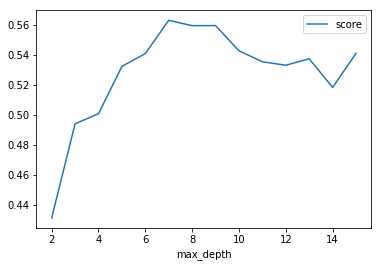

In [48]:
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)

gsc = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)


dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] })
dataz.plot(x='max_depth')

可见‘max_depth’取7时较为合适。

In [49]:
cv_results=pd.DataFrame(gsc.cv_results_)


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\skle

In [50]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
frmean=gsc.cv_results_['mean_test_score'][index]
frstd=gsc.cv_results_['std_test_score'][index]
fr_score=cv_results.loc[3,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [51]:
print('mean_score:',frmean)
print('std_score:',frstd)

mean_score: [0.56297211]
std_score: [0.07462172]


In [52]:
dtree=DecisionTreeClassifier(max_depth=7)
dtree.fit(X_train,y_train)
f1_score(dtree.predict(X_test),y_test)

#f1_score(y_test,y_pre)

0.5572519083969466

### 随机森林

In [53]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)
clf = RandomForestClassifier(n_estimators=10000, max_depth=11,random_state=0)
clf.fit(X_train,y_train)
f1_score(clf.predict(X_test),y_test)

0.6212765957446807

## 假设检验

从结果上看似乎逻辑回归模型f1值更高，记逻辑回归的f1值为$F1_log$,决策树模型的f1值为$F1_fr$。现在我们提出如下假设：
$H_0:F1_{log}=F1_{fr}$
$H_1:F1_{log}>F1_{fr}$

In [54]:
from scipy import stats


In [55]:
stats.mstats.ttest_ind(log_score,fr_score).pvalue<0.5

True

拒绝原假设，可认为逻辑回归的f1值高于决策树模型。

## 附录

由于我们只提取了悉尼当地的天气，因而大大损失了数据量。接下来考虑使用所有的数据进行学习，因此我们需要将可能影响下雨的地理因素：风向与风力去除。

In [56]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

考虑某一气象站能获取的最基本的气象信息：

>一般氣象站測量的基本氣象要素包括溫度、濕度、風向、風速、氣壓和雨量。


因此我们的数据集只保留几项基本特征：温度，压力，湿度，风速，降水量。

In [57]:
weather_all=weather.drop(columns=['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm'])

In [58]:
weather_all.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000,371.000000


In [59]:
weather_all=weather_all.dropna()

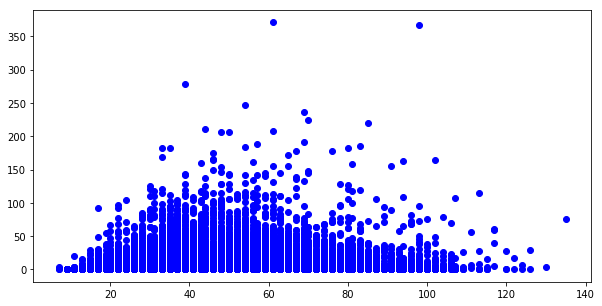

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(weather_all['WindGustSpeed'],weather_all['RISK_MM'],color='b')
plt.show()

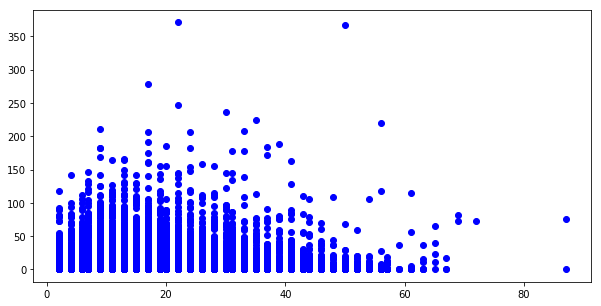

In [61]:
plt.figure(figsize=(10,5))
plt.scatter(weather_all['WindSpeed9am'],weather_all['RISK_MM'],color='b')
plt.show()

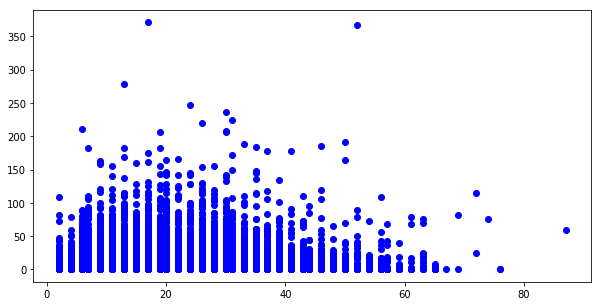

In [62]:
plt.figure(figsize=(10,5))
plt.scatter(weather_all['WindSpeed3pm'],weather_all['RISK_MM'],color='b')
plt.show()

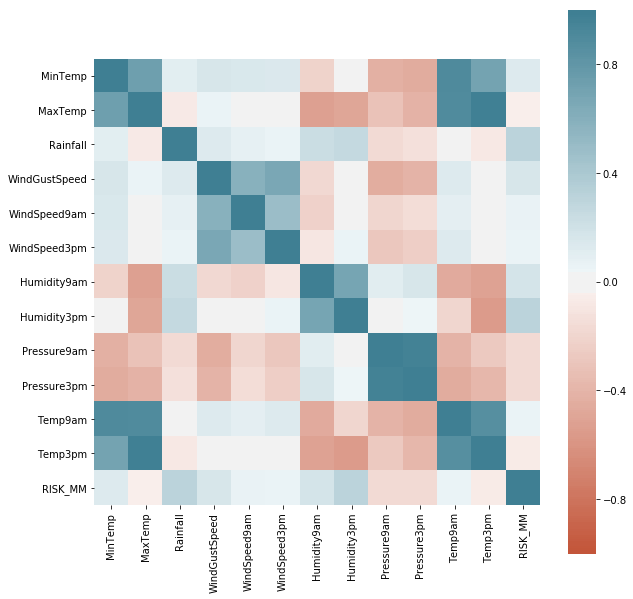

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(weather_all.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()

In [64]:
weather_all=weather_all.drop(columns=['WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm'])

In [65]:
weather_all=weather_all.drop(columns=['RainToday','Rainfall'])

In [66]:
weather_all=weather_all.replace('Yes',1)
weather_all=weather_all.replace('No',0)

In [67]:
weather_all.head()

,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM,RainTomorrow
0,13.4,22.9,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0
1,7.4,25.1,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0
2,12.9,25.7,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0
3,9.2,28.0,45.0,16.0,1017.6,1012.8,18.1,26.5,1.0,0
4,17.5,32.3,82.0,33.0,1010.8,1006.0,17.8,29.7,0.2,0


In [68]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(weather_all), columns = weather_all.columns)
X_scaled.head()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM,RainTomorrow
0,0.513064,0.446154,0.71,0.22,0.449587,0.4800,0.461894,0.446667,0.000000,0.0
1,0.370546,0.494505,0.44,0.25,0.497521,0.4912,0.468822,0.502222,0.000000,0.0
2,0.501188,0.507692,0.38,0.30,0.447934,0.5056,0.556582,0.477778,0.000000,0.0
3,0.413302,0.558242,0.45,0.16,0.613223,0.5712,0.489607,0.551111,0.002695,0.0
4,0.610451,0.652747,0.82,0.33,0.500826,0.4624,0.482679,0.622222,0.000539,0.0


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled[X_scaled.columns.difference(['RISK_MM','RainTomorrow'])], X_scaled['RISK_MM'], test_size=0.33, random_state=42)

In [70]:
X_train.head()

,Humidity3pm,Humidity9am,MaxTemp,MinTemp,Pressure3pm,Pressure9am,Temp3pm,Temp9am
13976,0.65,0.64,0.395604,0.581948,0.6416,0.573554,0.313333,0.526559
74639,0.89,0.72,0.573626,0.738717,0.5648,0.575207,0.535556,0.667436
13495,0.89,0.77,0.327473,0.465558,0.7088,0.710744,0.291111,0.454965
27229,0.36,0.78,0.329670,0.477435,0.3888,0.322314,0.326667,0.355658
25701,0.40,0.52,0.624176,0.598575,0.5728,0.576860,0.560000,0.570439


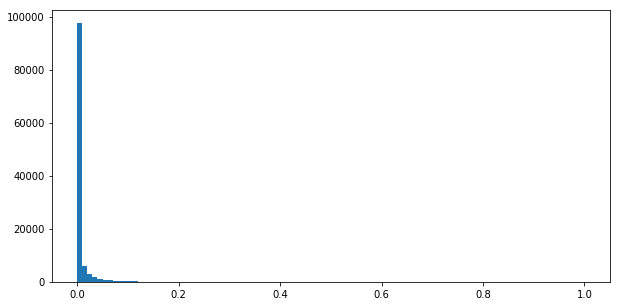

In [71]:
plt.figure(figsize=(10,5))
plt.hist(X_scaled['RISK_MM'],bins=100)
plt.show()

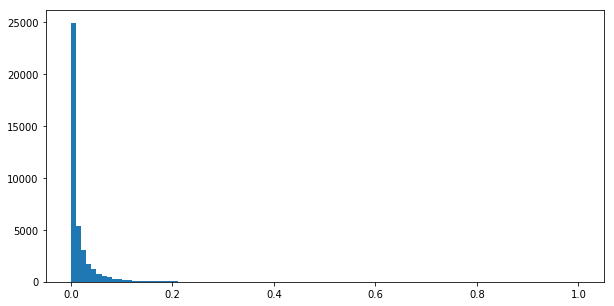

In [72]:
plt.figure(figsize=(10,5))
plt.hist(X_scaled[X_scaled['RISK_MM']!=0]['RISK_MM'],bins=100)
plt.show()

In [73]:
weather_all['RainTomorrow'].value_counts()

0    87906
1    25019
Name: RainTomorrow, dtype: int64

### 逻辑回归

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled[X_scaled.columns.difference(['RISK_MM','RainTomorrow'])], X_scaled['RainTomorrow'], test_size=0.33, random_state=42)


In [ ]:
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [85]:
log=LogisticRegression(class_weight={0: 0.33421052631578946, 1: 0.6657894736842105})
log.fit(X_train,y_train)
f1_score(log.predict(X_test),y_test)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6078799249530956

In [89]:
print(classification_report(y_test, log.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88     28874
         1.0       0.60      0.62      0.61      8392

   micro avg       0.82      0.82      0.82     37266
   macro avg       0.74      0.75      0.75     37266
weighted avg       0.82      0.82      0.82     37266



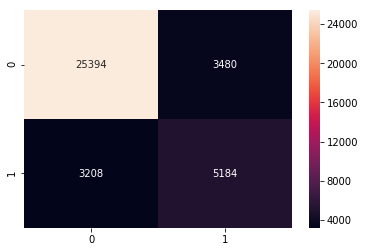

In [87]:
confMatrix = confusion_matrix(y_test, log.predict(X_test))
sns.heatmap(confMatrix, annot=True, fmt="d")

In [76]:
X_train.columns

Index(['Humidity3pm', 'Humidity9am', 'MaxTemp', 'MinTemp', 'Pressure3pm',
       'Pressure9am', 'Temp3pm', 'Temp9am'],
      dtype='object')

In [77]:
log.coef_

array([[ 5.86271117,  0.24551952,  1.07660726,  2.20830234, -9.0080559 ,
         2.40804019, -3.05916623, -1.73584763]])

In [78]:
pd.DataFrame(data={'feature':list(X_train.columns),'coef':log.coef_[0]})

,feature,coef
0,Humidity3pm,5.862711
1,Humidity9am,0.245520
2,MaxTemp,1.076607
3,MinTemp,2.208302
4,Pressure3pm,-9.008056
5,Pressure9am,2.408040
6,Temp3pm,-3.059166
7,Temp9am,-1.735848


### 线性回归

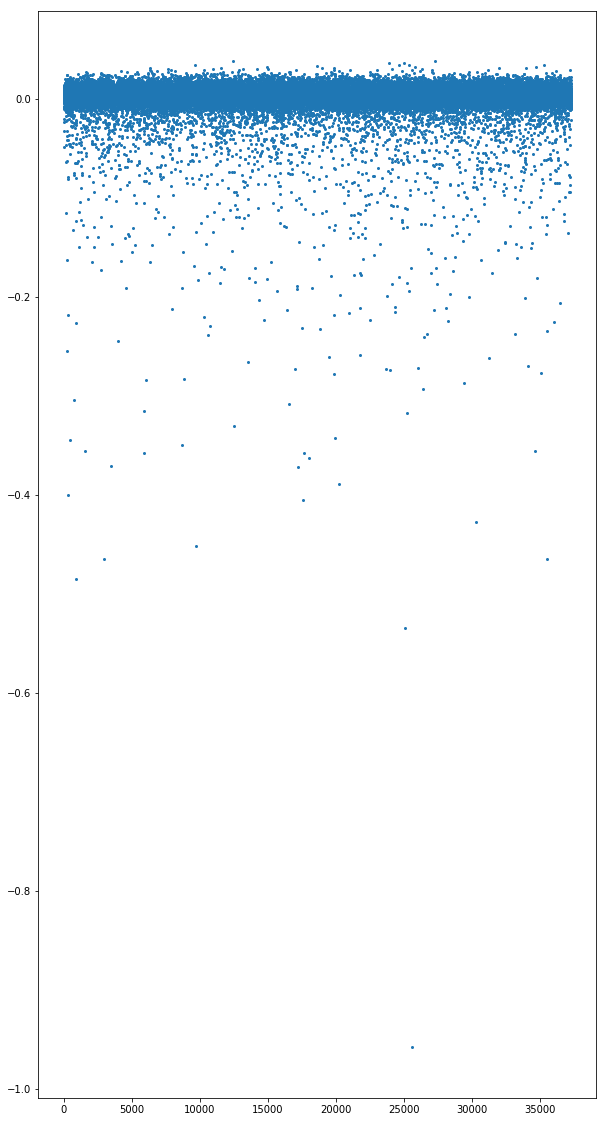

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled[X_scaled.columns.difference(['RISK_MM','RainTomorrow'])], X_scaled['RISK_MM'], test_size=0.33, random_state=42)
lin=LinearRegression()
lin.fit(X_train,y_train)
y_pre=lin.predict(X_test)

plt.figure(figsize=(10,20))
plt.scatter(range(len(X_test)),y_pre-y_test,s=4)
plt.show()

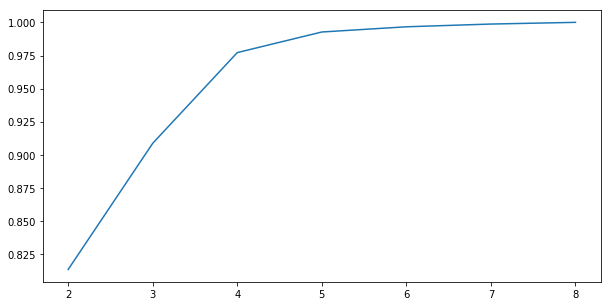

In [80]:
ratio=[]
for n in [2,3,4,5,6,7,8]:
    pca=PCA(n_components=n)
    pca.fit(X_train)  
    ratio.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize=(10,5))
plt.plot([2,3,4,5,6,7,8],ratio)
plt.show()

可见降维至5个特征即可解释近0.99的数据。

In [81]:
pca=PCA(n_components=5)
pca.fit(X_train)  
X_train=pca.transform(X_train)

In [82]:
np.array(X_train).shape

(75659, 5)

In [83]:
log=LogisticRegression()
log.fit(X_train,y_train)
f1_score(log.predict(pca.transform(X_test)),y_test)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Unknown label type: 'continuous'

In [ ]:
weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     28874
         1.0       0.72      0.44      0.55      8392

   micro avg       0.84      0.84      0.84     37266
   macro avg       0.79      0.70      0.73     37266
weighted avg       0.83      0.84      0.82     37266



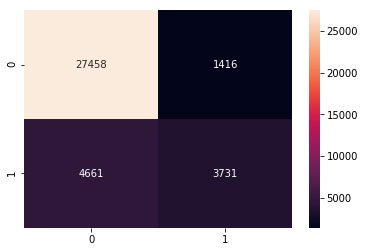

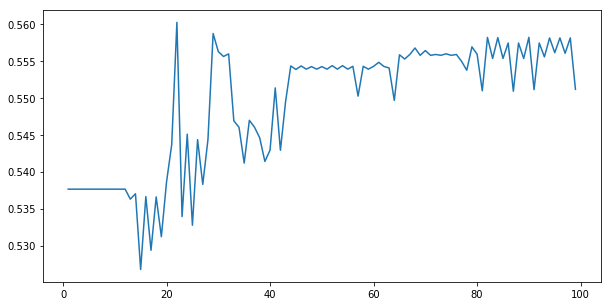

In [102]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_scaled[X_scaled.columns.difference(['RISK_MM','RainTomorrow'])], X_scaled['RainTomorrow'], test_size=0.33, random_state=42)
f1=[]
for n in range(1,100):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=n)

    bdt.fit(X_train, y_train)
    y_pre=bdt.predict(X_test)
    f1.append(f1_score(y_pre,y_test))
    
print(classification_report(y_test, y_pre))
confMatrix = confusion_matrix(y_test, y_pre)
sns.heatmap(confMatrix, annot=True, fmt="d")

plt.figure(figsize=(10,5))
plt.plot(range(1,100),f1)
plt.show()